In [26]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from pathlib import Path
from PIL import Image as pil
from PIL.Image import Image
from shutil import move, copy

from vkyn import *

In [27]:
SEED = 1337

IMAGE_SIZE = (300, 300) # EfficientNetB3
BATCH_SIZE = 128

In [28]:
def build_model(input_shape, num_classes: int, dropout_rate: float):
    inputs = tf.keras.layers.Input(shape=input_shape)
    cnn = tf.keras.applications.EfficientNetB3(
        input_tensor=inputs,
        include_top=False,
        weights="imagenet",
    )

    # Freeze the pretrained weights
    cnn.trainable = False

    # Rebuild top
    avg_pool = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(cnn.output)
    x = tf.keras.layers.BatchNormalization()(avg_pool)

    # Dropout
    if dropout_rate > 0:
        x = tf.keras.layers.Dropout(dropout_rate, name="top_dropout")(x)

    # Output
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes
    outputs = tf.keras.layers.Dense(units, activation=activation, name="pred")(x)

    return tf.keras.Model(inputs, outputs, name="VKYN01"), (inputs, cnn, avg_pool, outputs)

In [29]:
# Create an instance of model
model, _ = build_model(
    input_shape=IMAGE_SIZE + (3,),
    num_classes=2,
    dropout_rate=0.3,
)

In [30]:
model.load_weights("./weights/vkyn01-tf-efficientnetb3_5_epochs_dropout_03_learningrate1e-3_epochs.keras")

In [31]:
def process_image(path: Path):
    img = tf.keras.preprocessing.image.load_img(path, target_size=IMAGE_SIZE)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    return img_array

def predict_image(model, path: Path) -> dict[str, float]:
    img_array = process_image(path)
    predictions = model.predict(img_array, verbose=0)
    score = predictions[0][0]
    return {
        "y": score,
        "n": 1 - score,
    }

In [32]:
exampleImage ="H:/Datasets/MagistracyDiploma/Images/vaska/-33_457365666.jpg"

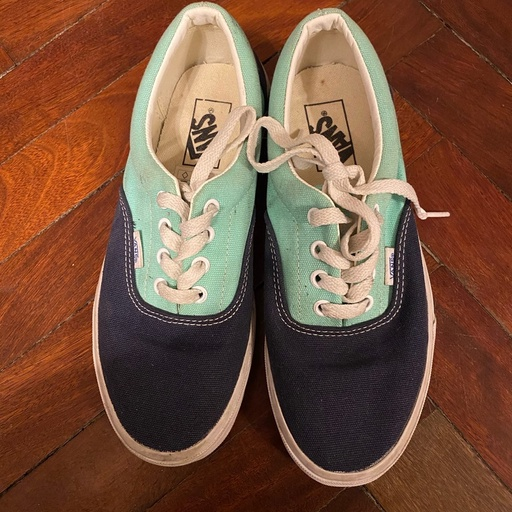

In [33]:
from IPython.display import Image
Image(filename=exampleImage)

In [34]:
predict_image(model, exampleImage)

{'y': np.float32(0.00018333652), 'n': np.float32(0.99981666)}

In [36]:
VaskaDataSetPath = "H:/Datasets/MagistracyDiploma/Images/vaska"

In [37]:
VaskaImagesLess02 = "H:/Datasets/MagistracyDiploma/Images/vaska_bad"

In [ ]:
for f in Path(VaskaDataSetPath).glob("*.jpg"):
    p = predict_image(model, f)
    if p["n"] > 0.7:
        print(f.name, p)
        move(f, VaskaImagesLess02)

-100056933_456239277.jpg {'y': np.float32(0.20445925), 'n': np.float32(0.79554075)}
